In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Analysis of User-defined Metabolite Sets

This notebook demonstrates how PALS can be used to analyse user-defined metabolite sets. Here PALS is used to analyse Molecular Families from GNPS, as well as Mass2Motifs from MS2LDA for differentially expressed metabolite sets.

In [2]:
import os
import sys
import pathlib
import pickle

sys.path.append('..')

In [3]:
import pandas as pd
import zipfile
import seaborn as sns
import matplotlib.patches as mpatches
from IPython.display import display, HTML
from loguru import logger

In [4]:
from pals.feature_extraction import DataSource
from pals.loader import GNPSLoader
from pals.PLAGE import PLAGE
from pals.common import *

2020-05-19 22:51:53.741 | INFO     | pals.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


## GNPS Molecular Family Analysis

### Load GNPS results using the loader

The loader is used to retrieve molecular networking results from GNPS and extract the necessary data for PALS analysis. 

Input:
- URL to FBMN GNPS results
- A metadata CSV

Provide the link to your FBMN GNPS experiment results below

In [5]:
database_name = DATABASE_GNPS_MOLECULAR_FAMILY
gnps_url = 'https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=0a8432b5891a48d7ad8459ba4a89969f'

Provide a metadata CSV file describing the sample groups

In [6]:
metadata_file = os.path.join('test_data', 'AGP', 'AG_Plants_extremes_metadata_df.csv')
metadata_df = pd.read_csv(metadata_file)
metadata_df

,sample,group
0,11337_P4_RE11_01_484.mzML,Less than 10
1,13313_P4_RE2_01_474.mzML,Less than 10
2,22510_P3_RG10_01_390.mzML,Less than 10
3,27840_P1_RG3_01_118.mzML,Less than 10
4,28742_P6_RH3_01_699.mzML,Less than 10
...,...,...
81,41935_P1_RG11_01_126.mzML,More than 30
82,42739_P3_RH1_01_395.mzML,More than 30
83,43160_P3_RE11_01_361.mzML,More than 30
84,49025_P6_RA4_01_676.mzML,More than 30


Define case and control groups, and create a comparison.

In [7]:
case = 'More than 30'
control = 'Less than 10'
comp_name = 'more_plants/no_plants'
comparisons = [{'case': case, 'control': control, 'name': comp_name },]
comparisons

[{'case': 'More than 30',
  'control': 'Less than 10',
  'name': 'more_plants/no_plants'}]

Instantiate the loader object, and load the data into a `database` object.

In [8]:
loader = GNPSLoader(database_name, gnps_url, metadata_df, comparisons)
database = loader.load_data()

2020-05-19 22:51:54.054 | INFO     | pals.loader:load_data:165 - Retrieving clustering and quantification information from GNPS
2020-05-19 22:51:54.055 | DEBUG    | pals.loader:load_data:166 - https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=0a8432b5891a48d7ad8459ba4a89969f
2020-05-19 22:51:54.056 | INFO     | pals.loader:_download_gnps:365 - Found GNPS task 0a8432b5891a48d7ad8459ba4a89969f
39.8MiB [00:13, 6.81MiB/s]2020-05-19 22:52:08.030 | DEBUG    | pals.loader:_parse_gnps_molfam:410 - Found cluster info: clusterinfo_summary/cffab31fda574b1f961b8b336a3fc9bd.tsv
2020-05-19 22:52:08.110 | DEBUG    | pals.loader:_parse_gnps_molfam:415 - Found quantification table: quantification_table/quantification_table-00000.csv
40.0MiB [00:13, 2.90MiB/s]


Create data source. For the GNPS database, we get *measurement_df*, *annotation_df* and *experimental_design* parameters from *database* before passing them to the *DataSource* constructor.

In [9]:
measurement_df = database.extra_data['measurement_df']
annotation_df = database.extra_data['annotation_df']
experimental_design = database.extra_data['experimental_design']

In [10]:
measurement_df.head()

,11337_P4_RE11_01_484.mzML,13313_P4_RE2_01_474.mzML,22510_P3_RG10_01_390.mzML,27840_P1_RG3_01_118.mzML,28742_P6_RH3_01_699.mzML,30483_P1_GD1_01_145.mzML,37543_P6_RG2_01_695.mzML,37937_P6_RD2_01_686.mzML,38057_P5_RE1_01_602.mzML,38093_P5_RE5_01_606.mzML,...,41323_P1_RG12_01_127.mzML,41341_P2_RE8_01_224.mzML,41534_P6_RB1_01_677.mzML,41698_P3_RC9_01_329.mzML,41744_P6_RE1_01_688.mzML,41935_P1_RG11_01_126.mzML,42739_P3_RH1_01_395.mzML,43160_P3_RE11_01_361.mzML,49025_P6_RA4_01_676.mzML,5990_P2_RB6_01_175.mzML
peak_id,,,,,,,,,,,,,,,,,,,,,
1,16621.9880,7.116694e+04,6.055347e+05,1095.7485,1.140599e+06,14605.3060,4.579952e+04,1.098218e+06,9.364128e+03,1.653913e+04,...,1715.1885,1.936919e+06,1.551468e+05,8492.3235,2.391372e+05,94469.0770,1.985232e+06,3.165443e+05,291132.561,57110.3940
2,226.5455,1.566927e+04,5.025617e+04,395148.9380,1.934524e+05,142826.9005,4.360585e+02,1.532759e+05,2.788818e+04,1.289885e+04,...,145.8310,4.268199e+05,6.492751e+03,7720.6630,1.263886e+04,480.2375,5.066707e+05,1.663545e+04,20276.257,168.3725
3,992235.6470,1.293665e+06,1.181147e+06,0.0000,9.435760e+05,0.0000,1.147643e+06,9.106171e+05,1.458229e+06,1.350834e+06,...,0.0000,0.000000e+00,1.673888e+06,14355.9335,1.304436e+06,0.0000,1.380754e+06,1.227284e+06,1444913.288,0.0000
4,931484.0325,1.214219e+06,9.357495e+05,0.0000,7.189252e+05,145.0350,7.851636e+05,6.281846e+05,1.044920e+06,9.298224e+05,...,269.6995,0.000000e+00,1.086346e+06,7135.2980,9.033790e+05,694.5275,1.056104e+06,9.832828e+05,1043496.384,433.5000
5,810685.3930,8.649341e+05,4.130054e+05,2470.5085,7.716864e+05,2717.1375,6.570987e+05,4.635221e+05,8.705470e+02,1.174299e+03,...,2350.6205,1.245302e+03,1.519240e+06,709596.0825,1.246027e+06,2860.2950,2.444535e+06,4.618985e+05,1872717.354,3621.1830


In [11]:
annotation_df.head()

,entity_id
peak_id,
2,2
4,4
5,5
6,6
7,7


### Create data source and run PLAGE analysis

Create a PALS data source and run PLAGE analysis.

In [12]:
gnps_ds = DataSource(measurement_df, annotation_df, experimental_design, None, database=database, min_replace=SMALL)

2020-05-19 22:52:09.000 | DEBUG    | pals.feature_extraction:__init__:47 - Using user-provided database
2020-05-19 22:52:09.001 | DEBUG    | pals.feature_extraction:__init__:55 - Mapping pathway to unique ids
2020-05-19 22:52:09.005 | DEBUG    | pals.feature_extraction:__init__:69 - Creating dataset to pathway mapping
2020-05-19 22:52:09.461 | DEBUG    | pals.feature_extraction:__init__:97 - Computing unique id counts


In [13]:
plage = PLAGE(gnps_ds, num_resamples=1000)
pathway_df = plage.get_pathway_df(standardize=True)

2020-05-19 22:52:09.727 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:307 - Setting the zero intensity values in the dataframe
2020-05-19 22:52:09.754 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:309 - 0
2020-05-19 22:52:09.810 | DEBUG    | pals.feature_extraction:standardize_intensity_df:276 - Scaling the data across the sample: zero mean and unit variance
2020-05-19 22:52:09.876 | DEBUG    | pals.PLAGE:get_plage_activity_df:84 - Mean values of the rows in the DF is [-0.  0. -0. ...  0.  0. -0.]
2020-05-19 22:52:09.877 | DEBUG    | pals.PLAGE:get_plage_activity_df:85 - Variance in the rows of the DF is [1. 1. 1. ... 1. 1. 1.]
2020-05-19 22:52:10.566 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:96 - Calculating plage p-values with resampling
2020-05-19 22:52:10.567 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:103 - Comparison more_plants/no_plants
2020-05-19 22:52:10.567 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:111 - Resampling 0/1000
20

In [14]:
p_value_col = '%s p-value' % comp_name
count_col = 'unq_pw_F'
pathway_df.sort_values([p_value_col, count_col], ascending=[True, False], inplace=True)
pathway_df

,pw_name,more_plants/no_plants p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,more_plants/no_plants comb_p
65,Molecular Family #65,0.0,81,81,100.0,1.0,81.0,100.0,NaN
21,Molecular Family #21,0.0,64,64,100.0,1.0,64.0,100.0,NaN
223,Molecular Family #223,0.0,46,46,100.0,1.0,46.0,100.0,NaN
590,Molecular Family #590,0.0,33,33,100.0,1.0,33.0,100.0,NaN
781,Molecular Family #781,0.0,27,27,100.0,1.0,27.0,100.0,NaN
...,...,...,...,...,...,...,...,...,...
1993,Molecular Family #1993,1.0,2,2,100.0,1.0,2.0,100.0,NaN
318,Molecular Family #318,1.0,2,2,100.0,1.0,2.0,100.0,NaN
3543,Molecular Family #3543,1.0,2,2,100.0,1.0,2.0,100.0,NaN
655,Molecular Family #655,1.0,2,2,100.0,1.0,2.0,100.0,NaN


### Checking results

In [15]:
sns.set()
pd.set_option('display.max_colwidth', None)

In [16]:
# cmap = 'RdBu_r'
# cmap = 'jet'
cmap = 'vlag'

Filter significant molecular families by p-value. 

In [17]:
pval_threshold = 0.05
df = pathway_df[pathway_df[p_value_col] < pval_threshold]
df

,pw_name,more_plants/no_plants p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,more_plants/no_plants comb_p
65,Molecular Family #65,0.000000,81,81,100.0,1.0,81.0,100.0,NaN
21,Molecular Family #21,0.000000,64,64,100.0,1.0,64.0,100.0,NaN
223,Molecular Family #223,0.000000,46,46,100.0,1.0,46.0,100.0,NaN
590,Molecular Family #590,0.000000,33,33,100.0,1.0,33.0,100.0,NaN
781,Molecular Family #781,0.000000,27,27,100.0,1.0,27.0,100.0,NaN
...,...,...,...,...,...,...,...,...,...
2067,Molecular Family #2067,0.031540,2,2,100.0,1.0,2.0,100.0,NaN
539,Molecular Family #539,0.031989,4,4,100.0,1.0,4.0,100.0,NaN
918,Molecular Family #918,0.042275,2,2,100.0,1.0,2.0,100.0,NaN
319,Molecular Family #319,0.044115,2,2,100.0,1.0,2.0,100.0,NaN


Count how many significant molecular families having at least 10 members.

In [18]:
min_members = 10
df[df[count_col] >= min_members].shape

(34, 9)

Plot significant molecular families

In [19]:
all_samples = []
all_groups = []
for group in experimental_design['groups']:
    samples = experimental_design['groups'][group]
    all_samples.extend(samples)
    all_groups.extend([group] * len(samples))

In [20]:
entity_dict = gnps_ds.entity_dict
intensities_df = gnps_ds.standardize_intensity_df()

2020-05-19 22:52:13.818 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:307 - Setting the zero intensity values in the dataframe
2020-05-19 22:52:13.843 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:309 - 0
2020-05-19 22:52:13.909 | DEBUG    | pals.feature_extraction:standardize_intensity_df:276 - Scaling the data across the sample: zero mean and unit variance


Molecular Family #65
Molecular Family #21
Molecular Family #223
Molecular Family #590
Molecular Family #781
Molecular Family #148
pw_name                          Molecular Family #148
more_plants/no_plants p-value                        0
unq_pw_F                                            23
tot_ds_F                                            23
F_coverage                                         100
sf                                                   1
exp_F                                               23
Ex_Cov                                             100
more_plants/no_plants comb_p                       NaN
Name: 148, dtype: object


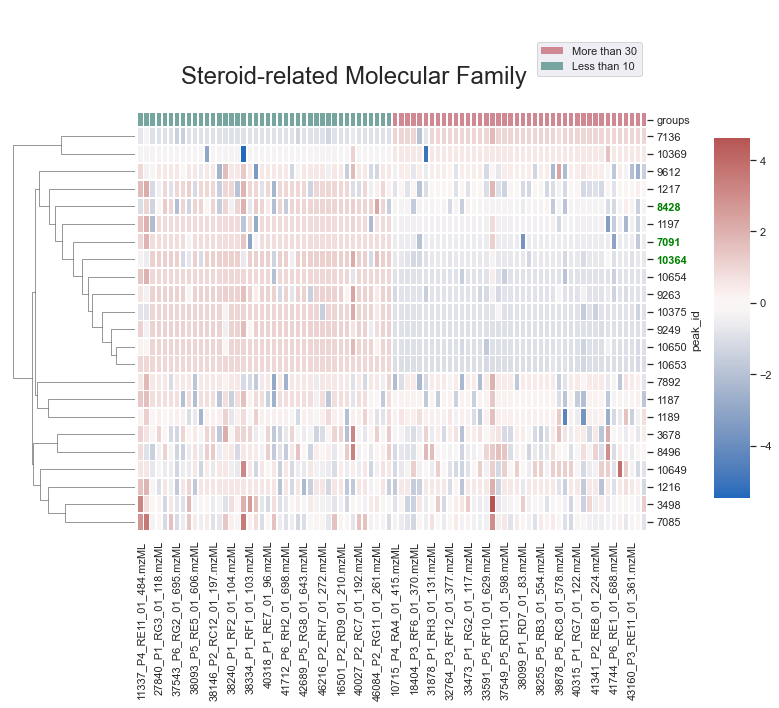

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
1187,NaN,357.2056,3.0498,0.037737,61,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
1189,NaN,385.2352,3.4066,0.005774,85,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
1197,NaN,343.2264,3.6391,0.018462,28,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
1216,NaN,367.2269,3.3133,0.003620,86,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
1217,NaN,339.1964,3.0423,0.003786,109,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
3498,NaN,769.4667,3.3526,0.001045,174,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
3678,NaN,399.3253,5.7595,0.000823,159,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
7085,NaN,713.4052,3.0489,0.003077,176,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
7091,Spectral Match to Mestranol from NIST14,311.2008,3.0540,0.001190,24,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f


Molecular Family #54
Molecular Family #215
Molecular Family #528
Molecular Family #95
Molecular Family #192
Molecular Family #279
Molecular Family #817
Molecular Family #321
Molecular Family #234
Molecular Family #107
Molecular Family #27
Molecular Family #522
Molecular Family #1443
Molecular Family #1923
Molecular Family #48
Molecular Family #806
Molecular Family #283
Molecular Family #59
Molecular Family #832
Molecular Family #643
Molecular Family #303
Molecular Family #715
Molecular Family #67
Molecular Family #720
Molecular Family #152
Molecular Family #117
Molecular Family #418
Molecular Family #454


In [21]:
for idx, row in df.iterrows():
    members = gnps_ds.dataset_pathways_to_row_ids[idx]
    if len(members) < min_members:
        continue
        
    pw_name = row['pw_name']
    p_value = row[p_value_col]
    print(pw_name)
    
    # plotting for manuscript
    to_plot = ['Molecular Family #148']
    if pw_name not in to_plot:
        continue
    else:
        print(row)
                
    # get group intensities
    group_intensities = intensities_df.loc[members][all_samples]    
    
    # get group info
    # print('%s p-value=%.4f' % (pw_name, p_value))
    data = []
    for member in members:
        member_info = entity_dict[member]
        unique_id = member_info['unique_id']
        library_id = member_info['LibraryID']
        gnps_linkout_network = member_info['GNPSLinkout_Network']
        no_spectra = member_info['number of spectra']
        rt = member_info['RT']
        mz = member_info['mass']    
        intensity = member_info['SumPeakIntensity']
        row = [unique_id, library_id, mz, rt, intensity, no_spectra, gnps_linkout_network]
        data.append(row)
    member_df = pd.DataFrame(data, columns=['id', 'LibraryID', 'Precursor m/z', 'RTConsensus', 'PrecursorInt', 'no_spectra', 'link']).set_index('id')    
    
    # Create a categorical palette to identify the networks
    used_groups = list(set(all_groups))
    group_pal = sns.husl_palette(len(used_groups), s=.45)
    group_lut = dict(zip(map(str, used_groups), group_pal))

    # Convert the palette to vectors that will be drawn on the side of the matrix
    group_colours = pd.Series(all_groups, index=group_intensities.columns).map(group_lut)    
    group_colours.name = 'groups'
    
    # plot heatmap
    g = sns.clustermap(group_intensities, center=0, cmap=cmap, col_colors=group_colours, 
                   col_cluster=False, linewidths=0.75, figsize=(10, 10), cbar_pos=(1.0, 0.3, 0.05, 0.5))
    
    title = pw_name
    if pw_name == 'Molecular Family #127':
        title = 'Cinnamic Acid-related Molecular Family'
    elif pw_name == 'Molecular Family #148':
        title = 'Steroid-related Molecular Family'
    plt.suptitle('%s' % (title), fontsize=24, y=0.9)

    # draw group legend
    for group in used_groups:
        g.ax_col_dendrogram.bar(0, 0, color=group_lut[group], label=group, linewidth=0)
    g.ax_col_dendrogram.legend(loc="right")
    
    # make the annotated peaks to have labels in bold
    annotated_df = member_df[member_df['LibraryID'].notnull()]
    annotated_peaks = annotated_df.index.values
    for label in g.ax_heatmap.get_yticklabels():
        if label.get_text() in annotated_peaks:
            label.set_weight("bold")
            label.set_color("green")   
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)        

    out_file = '%s.pdf' % pw_name
    plt.savefig(out_file, dpi=300)
    plt.show()
    
    out_file = '%s.csv' % pw_name
    display(member_df)
    member_df.drop('link', axis=1).round(4).to_csv(out_file, index=True)

## GNPS-MS2LDA Analysis

Similar to above, but here we provide a link to GNPS-MS2LDA analysis to retrieve Mass2Motifs, and pass it to the loader.

In [22]:
gnps_ms2lda_url = 'https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=7c34badae00e43bc87b195a706cf1f43'

In [23]:
database_name = DATABASE_GNPS_MS2LDA
loader = GNPSLoader(database_name, gnps_url, metadata_df, comparisons, gnps_ms2lda_url=gnps_ms2lda_url)
database = loader.load_data()

2020-05-19 22:52:15.755 | INFO     | pals.loader:load_data:165 - Retrieving clustering and quantification information from GNPS
2020-05-19 22:52:15.756 | DEBUG    | pals.loader:load_data:166 - https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=0a8432b5891a48d7ad8459ba4a89969f
2020-05-19 22:52:15.756 | INFO     | pals.loader:_download_gnps:365 - Found GNPS task 0a8432b5891a48d7ad8459ba4a89969f
39.8MiB [00:12, 5.03MiB/s]2020-05-19 22:52:29.578 | DEBUG    | pals.loader:_parse_gnps_molfam:410 - Found cluster info: clusterinfo_summary/cffab31fda574b1f961b8b336a3fc9bd.tsv
2020-05-19 22:52:29.674 | DEBUG    | pals.loader:_parse_gnps_molfam:415 - Found quantification table: quantification_table/quantification_table-00000.csv
40.0MiB [00:13, 2.95MiB/s]
2020-05-19 22:52:30.147 | INFO     | pals.loader:load_data:222 - Retrieving motif information from GNPS
2020-05-19 22:52:30.148 | DEBUG    | pals.loader:load_data:223 - https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=7c34badae00e43bc87b195a706cf1f

In [24]:
measurement_df = database.extra_data['measurement_df']
annotation_df = database.extra_data['annotation_df']
experimental_design = database.extra_data['experimental_design']
gnps_ds = DataSource(measurement_df, annotation_df, experimental_design, None, database=database, min_replace=SMALL)

2020-05-19 22:52:33.386 | DEBUG    | pals.feature_extraction:__init__:47 - Using user-provided database
2020-05-19 22:52:33.387 | DEBUG    | pals.feature_extraction:__init__:55 - Mapping pathway to unique ids
2020-05-19 22:52:33.391 | DEBUG    | pals.feature_extraction:__init__:69 - Creating dataset to pathway mapping
2020-05-19 22:52:33.857 | DEBUG    | pals.feature_extraction:__init__:97 - Computing unique id counts


In [25]:
plage = PLAGE(gnps_ds, num_resamples=1000)
pathway_df = plage.get_pathway_df(standardize=True)

2020-05-19 22:52:34.097 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:307 - Setting the zero intensity values in the dataframe
2020-05-19 22:52:34.122 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:309 - 0
2020-05-19 22:52:34.196 | DEBUG    | pals.feature_extraction:standardize_intensity_df:276 - Scaling the data across the sample: zero mean and unit variance
2020-05-19 22:52:34.254 | DEBUG    | pals.PLAGE:get_plage_activity_df:84 - Mean values of the rows in the DF is [-0.  0. -0. ...  0.  0. -0.]
2020-05-19 22:52:34.255 | DEBUG    | pals.PLAGE:get_plage_activity_df:85 - Variance in the rows of the DF is [1. 1. 1. ... 1. 1. 1.]
2020-05-19 22:52:34.653 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:96 - Calculating plage p-values with resampling
2020-05-19 22:52:34.653 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:103 - Comparison more_plants/no_plants
2020-05-19 22:52:34.653 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:111 - Resampling 0/1000
20

In [26]:
p_value_col = '%s p-value' % comp_name
count_col = 'unq_pw_F'
pathway_df.sort_values([p_value_col, count_col], ascending=[True, False], inplace=True)
pathway_df

,pw_name,more_plants/no_plants p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,more_plants/no_plants comb_p
motif_122,motif_122,0.0,91,77,84.62,0.027142,68.97,75.79,0.0
motif_188,motif_188,0.0,78,63,80.77,0.184479,59.12,75.79,0.0
motif_112,motif_112,0.0,67,51,76.12,0.541361,50.78,75.79,0.0
motif_149,motif_149,0.0,61,54,88.52,0.010195,46.23,75.79,0.0
motif_185,motif_185,0.0,61,47,77.05,0.477871,46.23,75.79,0.0
...,...,...,...,...,...,...,...,...,...
motif_214,motif_214,1.0,42,38,90.48,0.014086,31.83,75.79,1.0
motif_136,motif_136,1.0,38,33,86.84,0.073624,28.80,75.79,1.0
gnps_motif_59.m2m,gnps_motif_59.m2m [Fragments indicative for [phenylalanine-CHOOH] based substructure],1.0,33,20,60.61,0.984119,25.01,75.79,1.0
motif_218,motif_218,1.0,21,12,57.14,0.983704,15.92,75.81,1.0


In [27]:
df = pathway_df[pathway_df[p_value_col] < 0.05]
df

,pw_name,more_plants/no_plants p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,more_plants/no_plants comb_p
motif_122,motif_122,0.000000e+00,91,77,84.62,0.027142,68.97,75.79,0.000000e+00
motif_188,motif_188,0.000000e+00,78,63,80.77,0.184479,59.12,75.79,0.000000e+00
motif_112,motif_112,0.000000e+00,67,51,76.12,0.541361,50.78,75.79,0.000000e+00
motif_149,motif_149,0.000000e+00,61,54,88.52,0.010195,46.23,75.79,0.000000e+00
motif_185,motif_185,0.000000e+00,61,47,77.05,0.477871,46.23,75.79,0.000000e+00
motif_127,motif_127,0.000000e+00,43,43,100.00,0.000006,32.59,75.79,0.000000e+00
motif_198,motif_198,0.000000e+00,39,32,82.05,0.237857,29.56,75.79,0.000000e+00
motif_146,motif_146,0.000000e+00,15,14,93.33,0.090188,11.37,75.80,0.000000e+00
gnps_motif_170.m2m,gnps_motif_170.m2m [methoxy-methylaminophenyl substructure],0.000000e+00,12,11,91.67,0.173221,9.09,75.75,0.000000e+00
gnps_motif_54.m2m,gnps_motif_54.m2m [Fragments indicative for ferulic acid based substructure (MzCloud)],0.000000e+00,12,12,100.00,0.035748,9.09,75.75,0.000000e+00


In [28]:
entity_dict = gnps_ds.entity_dict
intensities_df = gnps_ds.standardize_intensity_df()

2020-05-19 22:52:36.385 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:307 - Setting the zero intensity values in the dataframe
2020-05-19 22:52:36.414 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:309 - 0
2020-05-19 22:52:36.484 | DEBUG    | pals.feature_extraction:standardize_intensity_df:276 - Scaling the data across the sample: zero mean and unit variance


gnps_motif_54.m2m [Fragments indicative for ferulic acid based substructure (MzCloud)]


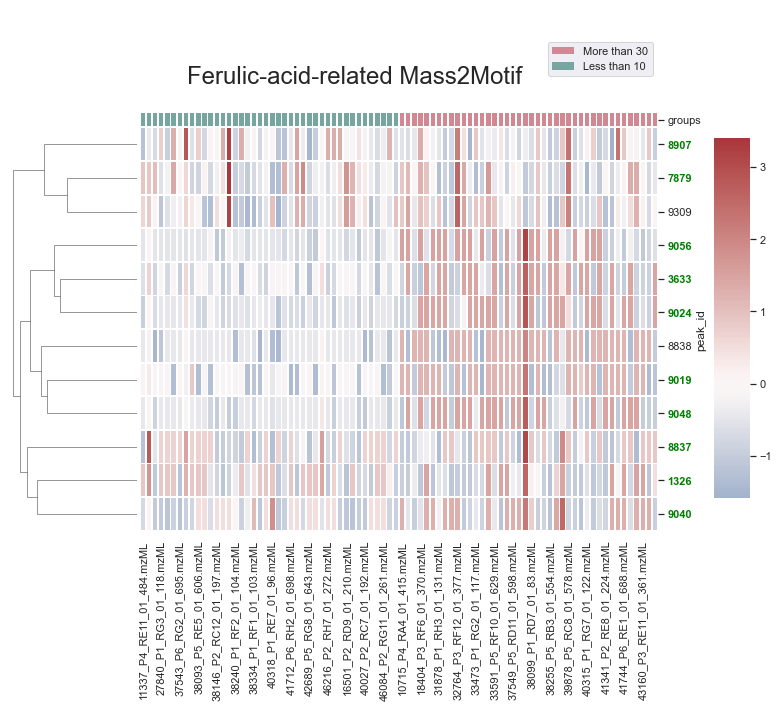

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
1326,Spectral Match to Curcumin from NIST14,369.1335,4.0253,0.032184,145,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=127&task=0a8432b5891a48d7ad8459ba4a89969f
3633,Spectral Match to Curcumin from NIST14,369.1336,3.1547,0.002445,97,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=127&task=0a8432b5891a48d7ad8459ba4a89969f
7879,Spectral Match to 3-Hydroxy-4-methoxycinnamic acid from NIST14,195.0655,2.4750,0.001998,192,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=127&task=0a8432b5891a48d7ad8459ba4a89969f
8837,Spectral Match to 3-Hydroxy-4-methoxycinnamic acid from NIST14,177.0538,4.0199,0.000481,127,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=127&task=0a8432b5891a48d7ad8459ba4a89969f
8838,NaN,371.1490,3.8366,0.004556,49,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=127&task=0a8432b5891a48d7ad8459ba4a89969f
8907,MoNA:3697220 Feruloyltyramine,265.1549,0.8890,0.001524,177,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=127&task=0a8432b5891a48d7ad8459ba4a89969f
9019,"NCGC00095321-06!(1E,4Z,6E)-5-hydroxy-1,7-bis(4-hydroxy-3-methoxyphenyl)hepta-1,4,6-trien-3-one",369.1332,4.2750,0.001551,85,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=127&task=0a8432b5891a48d7ad8459ba4a89969f
9024,"(1R,3R,4S,5R)-1,3,4-trihydroxy-5-[(E)-3-(4-hydroxyphenyl)prop-2-enoyl]oxycyclohexane-1-carboxylic acid",339.1230,3.1470,0.000508,103,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=127&task=0a8432b5891a48d7ad8459ba4a89969f
9040,Spectral Match to Curcumin from NIST14,369.1331,3.8770,0.003096,128,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=127&task=0a8432b5891a48d7ad8459ba4a89969f


In [30]:
for idx, row in df.iterrows():
    members = gnps_ds.dataset_pathways_to_row_ids[idx]
    if len(members) < min_members:
        continue
        
    pw_name = row['pw_name']
    p_value = row[p_value_col]
    
    if 'gnps_motif_54.m2m' not in pw_name:
        continue
    else:
        print(pw_name)
                
    # get group intensities
    group_intensities = intensities_df.loc[members][all_samples]    
    
    # get group info
    # print('%s p-value=%.4f' % (pw_name, p_value))
    data = []
    for member in members:
        member_info = entity_dict[member]
        unique_id = member_info['unique_id']
        library_id = member_info['LibraryID']
        gnps_linkout_network = member_info['GNPSLinkout_Network']
        no_spectra = member_info['number of spectra']
        rt = member_info['RT']
        mz = member_info['mass']    
        intensity = member_info['SumPeakIntensity']
        row = [unique_id, library_id, mz, rt, intensity, no_spectra, gnps_linkout_network]
        data.append(row)
    member_df = pd.DataFrame(data, columns=['id', 'LibraryID', 'Precursor m/z', 'RTConsensus', 'PrecursorInt', 'no_spectra', 'link']).set_index('id')    
    
    # Create a categorical palette to identify the networks
    used_groups = list(set(all_groups))
    group_pal = sns.husl_palette(len(used_groups), s=.45)
    group_lut = dict(zip(map(str, used_groups), group_pal))

    # Convert the palette to vectors that will be drawn on the side of the matrix
    group_colours = pd.Series(all_groups, index=group_intensities.columns).map(group_lut)    
    group_colours.name = 'groups'
    
    # plot heatmap
    g = sns.clustermap(group_intensities, center=0, cmap=cmap, col_colors=group_colours, 
                   col_cluster=False, linewidths=0.75, figsize=(10, 10), cbar_pos=(1.0, 0.3, 0.05, 0.5))

    title = pw_name
    if 'gnps_motif_54.m2m' in pw_name:
        title = 'Ferulic-acid-related Mass2Motif'
    plt.suptitle('%s' % (title), fontsize=24, y=0.9)

    # draw group legend
    for group in used_groups:
        g.ax_col_dendrogram.bar(0, 0, color=group_lut[group], label=group, linewidth=0)
    g.ax_col_dendrogram.legend(loc="right")
    
    # make the annotated peaks to have labels in bold
    annotated_df = member_df[member_df['LibraryID'].notnull()]
    annotated_peaks = annotated_df.index.values
    for label in g.ax_heatmap.get_yticklabels():
        if label.get_text() in annotated_peaks:
            label.set_weight("bold")
            label.set_color("green")   
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)        

    out_file = '%s.pdf' % pw_name
    plt.savefig(out_file, dpi=300)
    plt.show()
    
    out_file = '%s.csv' % pw_name
    display(member_df)
    member_df.drop('link', axis=1).round(4).to_csv(out_file, index=True)